# See Detailed code at https://github.com/aayush9753/ColorIt

## Importing Libraries

In [344]:
import glob
import random
import os
import numpy as np

import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from torch import nn
from matplotlib import pyplot as plt


import argparse
import os
import numpy as np
import math
import itertools
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch


from torchvision.models import vgg19

from skimage import color
from IPython import embed

## Util

In [345]:
def load_img(img_path):
	out_np = np.asarray(Image.open(img_path))
	if(out_np.ndim==2):
		out_np = np.tile(out_np[:,:,None],3)
	return out_np

def resize_img(img, HW=(256,256), resample=3):
	return np.asarray(Image.fromarray(img).resize((HW[1],HW[0]), resample=resample))

def preprocess_img(img_rgb_orig, HW=(256,256), resample=3):
	# return original size L and resized L as torch Tensors
	img_rgb_rs = resize_img(img_rgb_orig, HW=HW, resample=resample)
	
	img_lab_orig = color.rgb2lab(img_rgb_orig)
	img_lab_rs = color.rgb2lab(img_rgb_rs)

	img_l_orig = img_lab_orig[:,:,0]
	img_l_rs = img_lab_rs[:,:,0]

	tens_orig_l = torch.Tensor(img_l_orig)[None,None,:,:]
	tens_rs_l = torch.Tensor(img_l_rs)[None,None,:,:]

	return (tens_orig_l, tens_rs_l)

def postprocess_tens_new(tens_orig_l, out_ab, mode='bilinear'):
	# tens_orig_l 	Batchsize x 1 x H_orig x W_orig
	# out_ab 		Batchsize x 2 x H x W
    Batchsize = tens_orig_l.shape[0]

    output_ = []
    for i in range(Batchsize):
        tens_orig_l_i = tens_orig_l[i][np.newaxis, :, :, :]
        out_ab_i  = out_ab[i][np.newaxis, :, :, :]
        HW_orig_i = tens_orig_l_i.shape[2:]
        HW_i = out_ab_i.shape[2:]

        # call resize function if needed
        if(HW_orig_i[0]!=HW_i[0] or HW_orig_i[1]!=HW_i[1]):
            out_ab_orig_i = F.interpolate(out_ab_i, size=HW_orig_i, mode='bilinear')
        else:
            out_ab_orig_i = out_ab_i

        out_lab_orig_i = torch.cat((tens_orig_l_i, out_ab_orig_i), dim=1)
        #output_.append(color.lab2rgb(out_lab_orig_i.data.cpu().numpy()[0,...].transpose((1,2,0))))
        output_.append(color.lab2rgb(out_lab_orig_i.data.cpu().numpy()[0,...].transpose((1,2,0))).transpose((2,0,1)))
    return np.array(output_)

# Models
## ECV16
This Model is based on the paper Colorful Image Colorization https://arxiv.org/abs/1603.08511 which we will train using a GAN with the ECV Model (A normal residual convnet model proposed in the paper) as the generator and a discriminator that we will design.

In [346]:
class BaseColor(nn.Module):
	def __init__(self):
		super(BaseColor, self).__init__()

		self.l_cent = 50.
		self.l_norm = 100.
		self.ab_norm = 110.

	def normalize_l(self, in_l):
		return (in_l-self.l_cent)/self.l_norm

	def unnormalize_l(self, in_l):
		return in_l*self.l_norm + self.l_cent

	def normalize_ab(self, in_ab):
		return in_ab/self.ab_norm

	def unnormalize_ab(self, in_ab):
		return in_ab*self.ab_norm


class ECCVGenerator(BaseColor):
    def __init__(self, norm_layer=nn.BatchNorm2d):
        super(ECCVGenerator, self).__init__()

        model1=[nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[norm_layer(64),]

        model2=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[norm_layer(128),]

        model3=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[norm_layer(256),]

        model4=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[norm_layer(512),]

        model5=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[norm_layer(512),]

        model6=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[norm_layer(512),]

        model7=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[norm_layer(512),]

        model8=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]

        model8+=[nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0, bias=True),]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8 = nn.Sequential(*model8)

        self.softmax = nn.Softmax(dim=1)
        self.model_out = nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear')

    def forward(self, input_l):
        conv1_2 = self.model1(self.normalize_l(input_l))
        conv2_2 = self.model2(conv1_2)
        conv3_3 = self.model3(conv2_2)
        conv4_3 = self.model4(conv3_3)
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)
        conv8_3 = self.model8(conv7_3)
        out_reg = self.model_out(self.softmax(conv8_3))

        return self.unnormalize_ab(self.upsample4(out_reg))

def eccv16(pretrained=True):
	model = ECCVGenerator()
	if(pretrained):
		import torch.utils.model_zoo as model_zoo
		model.load_state_dict(model_zoo.load_url('https://colorizers.s3.us-east-2.amazonaws.com/colorization_release_v2-9b330a0b.pth',map_location='cpu',check_hash=True))
	return model


# Image Dataset

In [347]:
out_channels = 3

class ImageDataset(Dataset):
    def __init__(self, root, transform): 
        self.transform = transform

        self.files = sorted(glob.glob(root + "/*.*"))

    def __getitem__(self, index):
        
        black_path = self.files[index % len(self.files)]
        color_path = black_path.replace('black','color')
        
        img_black = np.asarray(Image.open(black_path))
        if(img_black.ndim==2):
            img_black = np.tile(img_black[:,:,None],3)
        (tens_l_orig, tens_l_rs) = preprocess_img(img_black, HW=(400, 400))

        img_color = Image.open(color_path)
        img_color = self.transform(img_color)

        return {"black": tens_l_rs.squeeze(0), 'orig': tens_l_orig.squeeze(0), "color": img_color}


    def __len__(self):
        return len(self.files)

root = 'data/test_black/'
transform = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
dataloader = DataLoader(
    ImageDataset(root, transform),
)

torch.Size([400, 400, 1])


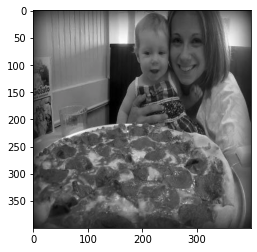

torch.Size([400, 400, 1])


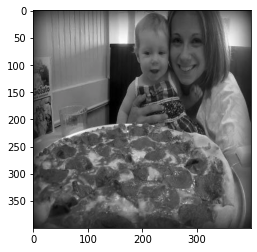

torch.Size([400, 400, 1])


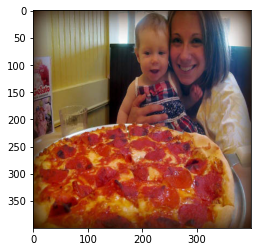

In [348]:
dataiter = iter(dataloader)
data = dataiter.next()

i = 0
img = data['black'][i].permute(1, 2, 0)
print(img.shape)
t = np.zeros((400, 400, 3))
t[..., 0] = img[..., 0]
t = color.lab2rgb(t)
plt.imshow(t)
plt.show()

img = data['orig'][i].permute(1, 2, 0)
print(img.shape)
t = np.zeros((400, 400, 3))
t[..., 0] = img[..., 0]
t = color.lab2rgb(t)
plt.imshow(t)
plt.show()

print(img.shape)
img = data['color'][i].permute(1, 2, 0)
plt.imshow(img)
plt.show()

# Initialising Models and Training Params

In [349]:
class color_ecv(nn.Module):
    def __init__(self, in_channels):
        super(color_ecv, self).__init__()
        
        self.model = eccv16(pretrained=True)
    
    def forward(self, x):
        ecv_output = self.model(x)
        return ecv_output

In [351]:
shape = (400, 400)

# Initialize generator and discriminator
generator = color_ecv(in_channels = 3)

dname = ['05','07','12','15','20','22','25','39','50','89']
modellist = [0,60,75,90]

In [352]:
def define_model(modelnum):
    if modelnum ==0 :
        generator.load_state_dict(torch.load(f"models/generator.pth", map_location=torch.device('cpu')))    
    else:
        generator.load_state_dict(torch.load(f"models/generator_{modelnum-1}.pth", map_location=torch.device('cpu')))
    return generator

# Output creation

In [353]:
Tensor = torch.Tensor
imageg = {i:[] for i in dname}
img_grid2 = {i:torch.randn(400, 400) for i in dname}


0


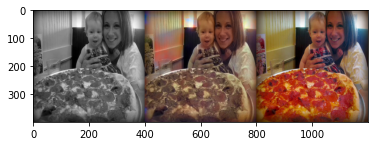

60


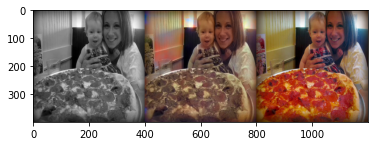

75


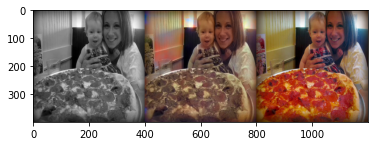

90


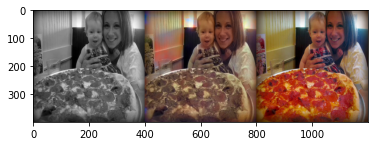

In [354]:
for modelnum in modellist:
    generator = define_model(modelnum)
    c=0
    for i, imgs in enumerate(dataloader):

        # imgs_black : Light Channel of the Image in Model Shape
        # imgs_black_orig : Light Channel of the Image in Original Image Shape
        # imgs_color : Colourfull Image Provided 
        # gen_ab : A and B channel generated by the generator
        # gen_color : Colourfull Image generated by the Generator after postprocessing
        
        # Configure model input
        imgs_black = Variable(imgs["black"].type(Tensor))
        imgs_black_orig = Variable(imgs["orig"].type(Tensor))
        imgs_color = Variable(imgs["color"].type(Tensor))

        
        

        # Generate a high resolution image from low resolution input
        gen_ab = generator(imgs_black)
        gen_color = postprocess_tens_new(imgs_black_orig, gen_ab)


        gen_color = make_grid(torch.tensor(gen_color), nrow=1, normalize=True)
        imgs_black_orig = make_grid(imgs_black_orig, nrow=1, normalize=True)
        imgs_color = make_grid(imgs_color, nrow=1, normalize=True)

        save_image(gen_color, f"data/output/50{dname[c]}_{modelnum}.jpg", normalize=False)

        img_grid = torch.cat((imgs_black_orig, gen_color, imgs_color), -1)
        save_image(img_grid, f"data/gridoutput/50{dname[c]}_{modelnum}.jpg", normalize=False)

        if modelnum == 0:
            imageg[dname[c]].append(imgs_black_orig)
        imageg[dname[c]].append(gen_color)
        if modelnum == 90:
            imageg[dname[c]].append(imgs_color)
            save_image(imgs_black_orig, f"data/output/50{dname[c]}_-1.jpg", normalize=False)
            save_image(imgs_color, f"data/output/50{dname[c]}_Color.jpg", normalize=False)
        img_grid2[dname[c]] = torch.cat(imageg[dname[c]], -1)
        if c==0:
            print(modelnum)
            transform = transforms.ToPILImage()
            img = transform(img_grid)
            plt.imshow(img)
            plt.show()
        c+=1
c=0
for i in img_grid2:
    save_image(img_grid2[i], f"data/gridoutput/50{dname[c]}_Full.jpg", normalize=False)
    c+=1


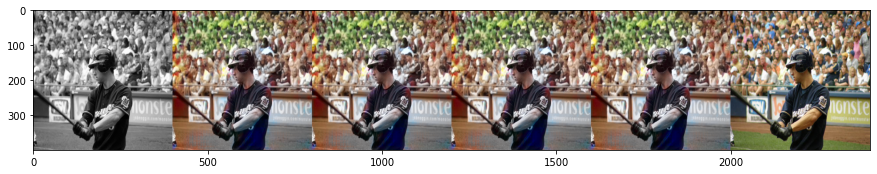

In [355]:
img = transform(img_grid2[dname[1]])
plt.figure(figsize=(15,60))
plt.imshow(img)
plt.show()